# Analysis of Kepler KOI data

Standalone notebook containing all steps to download, normalize and visualize transit light curves:
- Split train and test data.
- Feature extraction.
- Download KOI raw data.
- Normalization.
- Resampling.

## Load data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
import numpy as np
import random
import lightkurve as lk
import astropy.units as u

In [89]:
'''Loading data on a pandas' DataFrame.''' 
#Replace path with current data's path

path = '/data/cumulative_2019.11.09_03.28.25.csv'
data = pd.read_csv(path, sep = ',', comment = '#')
print(data.shape)
data = data[['kepid', 'kepoi_name', 'kepler_name', 'koi_disposition',
       'koi_pdisposition', 'koi_score', 'koi_period', 'koi_time0bk', 'koi_duration','koi_depth', 'koi_kepmag']]
data.head(10)

(9564, 49)


,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_period,koi_time0bk,koi_duration,koi_depth,koi_kepmag
0,10797460,K00752.01,Kepler-227 b,CONFIRMED,CANDIDATE,1.000,9.488036,170.538750,2.95750,615.8,15.347
1,10797460,K00752.02,Kepler-227 c,CONFIRMED,CANDIDATE,0.969,54.418383,162.513840,4.50700,874.8,15.347
2,10811496,K00753.01,NaN,CANDIDATE,CANDIDATE,0.000,19.899140,175.850252,1.78220,10829.0,15.436
3,10848459,K00754.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,1.736952,170.307565,2.40641,8079.2,15.597
4,10854555,K00755.01,Kepler-664 b,CONFIRMED,CANDIDATE,1.000,2.525592,171.595550,1.65450,603.3,15.509
5,10872983,K00756.01,Kepler-228 d,CONFIRMED,CANDIDATE,1.000,11.094321,171.201160,4.59450,1517.5,15.714
6,10872983,K00756.02,Kepler-228 c,CONFIRMED,CANDIDATE,1.000,4.134435,172.979370,3.14020,686.0,15.714
7,10872983,K00756.03,Kepler-228 b,CONFIRMED,CANDIDATE,0.992,2.566589,179.554370,2.42900,226.5,15.714
8,6721123,K00114.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.000,7.361790,132.250530,5.02200,233.7,12.660
9,10910878,K00757.01,Kepler-229 c,CONFIRMED,CANDIDATE,1.000,16.068647,173.621937,3.53470,4914.3,15.841


### KOI labels

kepid  kepoi_name  kepler_name  koi_score  \
koi_pdisposition koi_disposition                                              
CANDIDATE        CANDIDATE         2420        2420            0       1816   
                 CONFIRMED         2296        2296         2296       2285   
                 FALSE POSITIVE       1           1            1          1   
FALSE POSITIVE   CONFIRMED            7           7            7          6   
                 FALSE POSITIVE    4840        4840            1       3946   

                                  koi_period  koi_time0bk  koi_duration  \
koi_pdisposition koi_disposition                                          
CANDIDATE        CANDIDATE              2420         2420          2420   
                 CONFIRMED              2296         2296          2296   
                 FALSE POSITIVE            1            1             1   
FALSE POSITIVE   CONFIRMED                 7            7             7   
                 FALSE POSITIVE         4840         4840          4840   

                                  koi_depth  koi_kepmag  
koi_pdisposition koi_disposition                         
CANDIDATE        CANDIDATE             2315        2420  
                 CONFIRMED             2296        2296  
                 FALSE POSITIVE           1           1  
FALSE POSITIVE   CONFIRMED                6           7  
                 FALSE POSITIVE        4583        4839

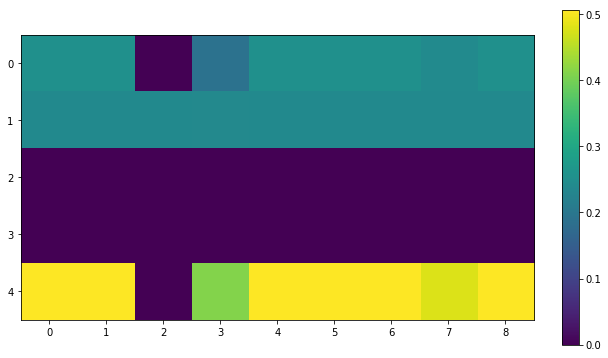

In [26]:
cross_labels = data.groupby(['koi_pdisposition', 'koi_disposition']).count()
display(cross_labels)
total = cross_labels.kepid.sum()
plt.figure(figsize = (10,10))
plt.imshow(cross_labels.to_numpy()/total, aspect = 'equal')
plt.colorbar(fraction = 0.03)
plt.show()

We are missing some 'koi_score' values and a few 'koi_depth (almost half od candidates doesn't have score)

Two KOIs Falsep labelled have kepler names

In [27]:
'''Checking for NaNS and nulls'''
print('NaNs: \n\n', data.isna().sum(),'\n\n')
print('Nulls: \n\n', data.isnull().sum())

NaNs: 

 kepid                  0
kepoi_name             0
kepler_name         7259
koi_disposition        0
koi_pdisposition       0
koi_score           1510
koi_period             0
koi_time0bk            0
koi_duration           0
koi_depth            363
koi_kepmag             1
dtype: int64 


Nulls: 

 kepid                  0
kepoi_name             0
kepler_name         7259
koi_disposition        0
koi_pdisposition       0
koi_score           1510
koi_period             0
koi_time0bk            0
koi_duration           0
koi_depth            363
koi_kepmag             1
dtype: int64


Perfect!! No NaNs on labels we care about

In [28]:
'''Just to make sure there is no NaNs'''

data[data.values == -99]  #NaN values where set as -99 during Q1-6 (see doc)

,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_period,koi_time0bk,koi_duration,koi_depth,koi_kepmag


In [29]:
'''Just to make sure there is no NaNs'''

data[data.values == 99]  #NaN values where set as 99 during Q1-6 (see doc)

,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_period,koi_time0bk,koi_duration,koi_depth,koi_kepmag
3816,9718066,K02287.02,Kepler-378 c,CONFIRMED,CANDIDATE,0.08,28.906053,158.82431,3.0990,99.0,12.485
8389,9655424,K07218.01,NaN,FALSE POSITIVE,FALSE POSITIVE,0.00,0.518118,131.64600,0.3969,99.0,14.890


For now wedont care about koi_depth

## Physical agreement

General time plotting by label

CANDIDATE



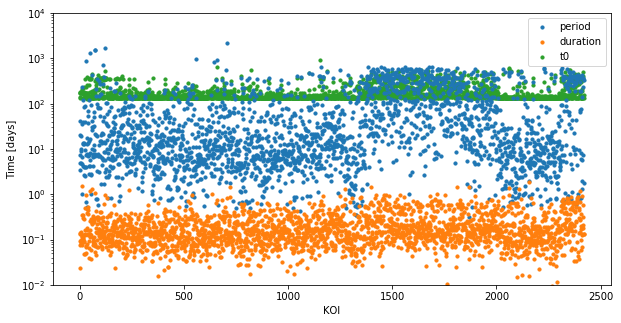

FALSE POSITIVE



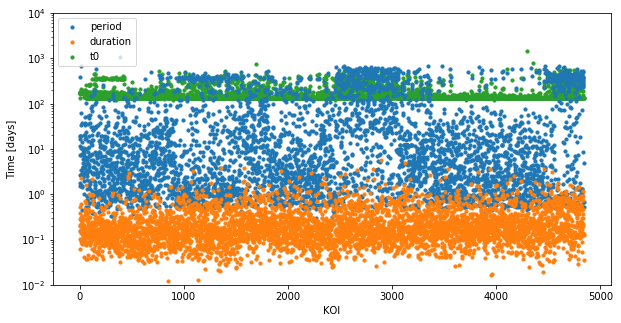

CONFIRMED



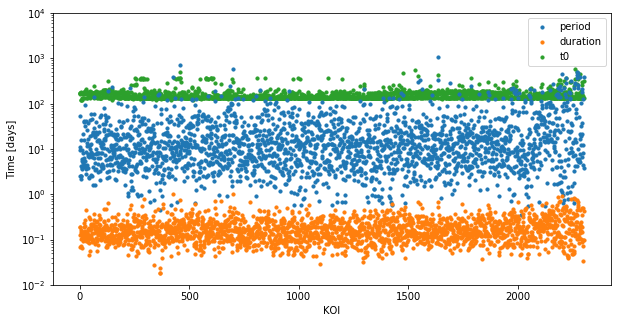

In [105]:
for i in ['CANDIDATE', 'FALSE POSITIVE', 'CONFIRMED']:   #For each label
    '''Select only KOI with that label'''
    data_type = data[data.koi_disposition == i]   #Df 
    kid = data_type.kepoi_name                        #KOI id
    period = data_type.koi_period                 #KOI period
    duration = data_type.koi_duration/24             #KOI transit duration
    t0 = data_type.koi_time0bk                    #Fisrt apperance Kepler time
    mag = data_type.koi_kepmag
    
    print(i + '\n')                               #Plotting all three times
    plt.figure(figsize = (10,5))
    plt.scatter(range(len(period)), period, s = 10)
    plt.scatter(range(len(period)), duration, s = 10)
    plt.scatter(range(len(period)), t0, s = 10, zorder = 0)
    plt.yscale('log')
    plt.ylim([0.01,10**4])
    plt.legend(['period', 'duration', 't0'])
    plt.ylabel('Time [days]')
    plt.xlabel('KOI')
    plt.show()

CANDIDATE



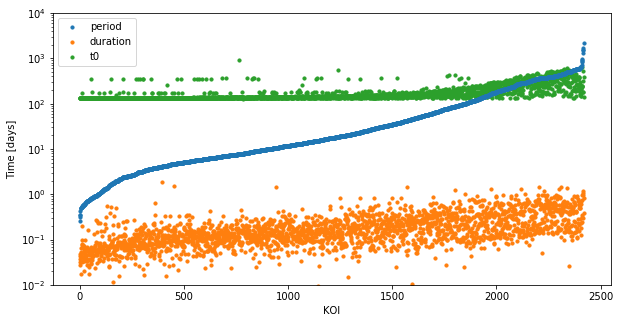

FALSE POSITIVE



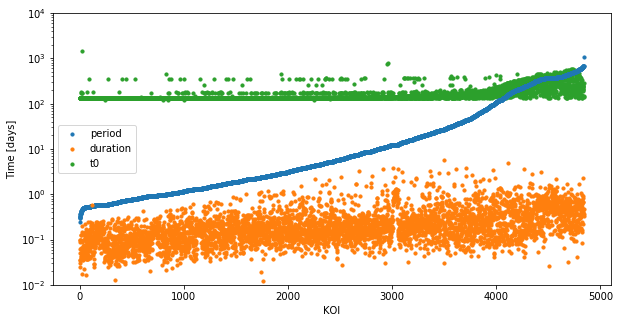

CONFIRMED



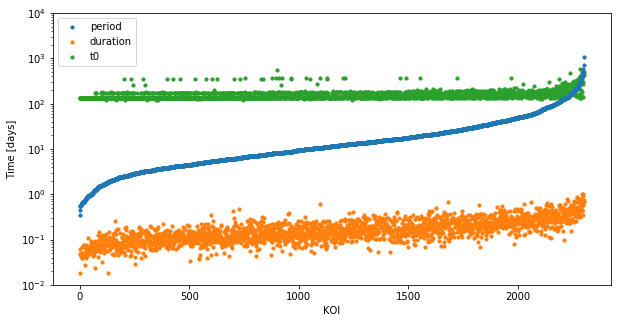

In [106]:
for i in ['CANDIDATE', 'FALSE POSITIVE', 'CONFIRMED']:   #For each label
    '''Select only KOI with that label'''
    data_type = data[data.koi_disposition == i].sort_values('koi_period')   #Df 
    kid = data_type.kepoi_name                        #KOI id
    period = data_type.koi_period                 #KOI period
    duration = data_type.koi_duration/24             #KOI transit duration
    t0 = data_type.koi_time0bk                    #Fisrt apperance Kepler time
    mag = data_type.koi_kepmag
    
    print(i + '\n')                               #Plotting all three times
    plt.figure(figsize = (10,5))
    plt.scatter(range(len(period)), period, s = 10)
    plt.scatter(range(len(period)), duration, s = 10)
    plt.scatter(range(len(period)), t0, s = 10, zorder = 0)
    plt.yscale('log')
    plt.legend(['period', 'duration', 't0'])
    plt.ylim([0.01,10**4])
    plt.ylabel('Time [days]')
    plt.xlabel('KOI')
    plt.show()

CANDIDATE



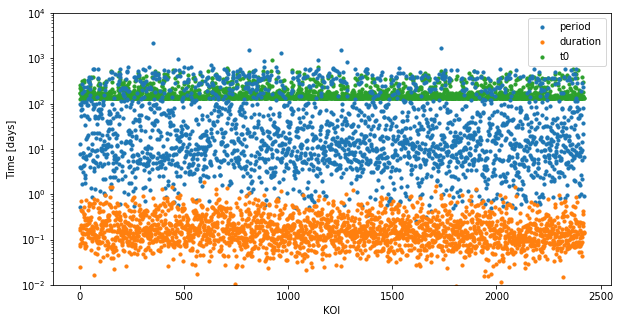

FALSE POSITIVE



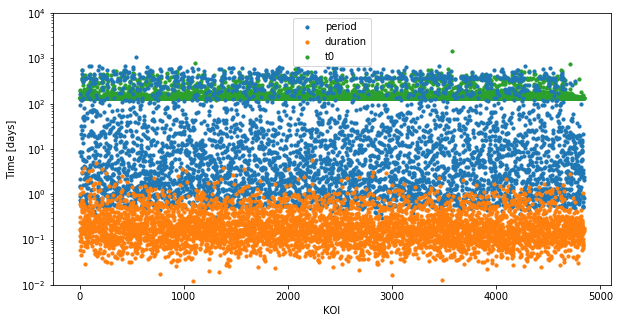

CONFIRMED



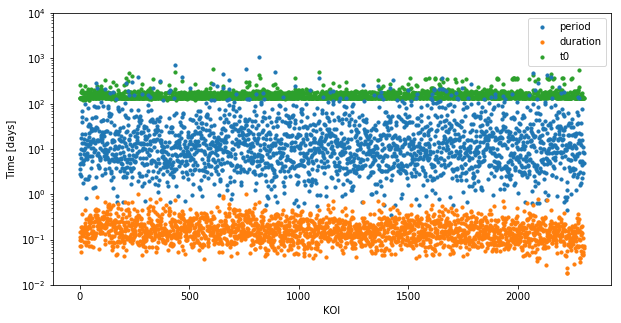

In [101]:
for i in ['CANDIDATE', 'FALSE POSITIVE', 'CONFIRMED']:   #For each label
    '''Select only KOI with that label'''
    data_type = data[data.koi_disposition == i].sort_values(['koi_kepmag'])   #Df 
    kid = data_type.kepoi_name                        #KOI id
    period = data_type.koi_period                 #KOI period
    duration = data_type.koi_duration/24             #KOI transit duration
    t0 = data_type.koi_time0bk                    #Fisrt apperance Kepler time
    mag = data_type.koi_kepmag
    
    print(i + '\n')                               #Plotting all three times
    plt.figure(figsize = (10,5))
    plt.scatter(range(len(period)), period, s = 10)
    plt.scatter(range(len(period)), duration, s = 10)
    plt.scatter(range(len(period)), t0, s = 10, zorder = 0)
    plt.yscale('log')
    plt.legend(['period', 'duration', 't0'])
    plt.ylim([0.01,10**4])
    plt.ylabel('Time [days]')
    plt.xlabel('KOI')
    plt.show()


 CANDIDATE


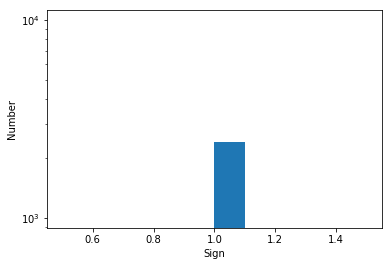

[   0.    0.    0.    0.    0. 2420.    0.    0.    0.    0.]

 FALSE POSITIVE


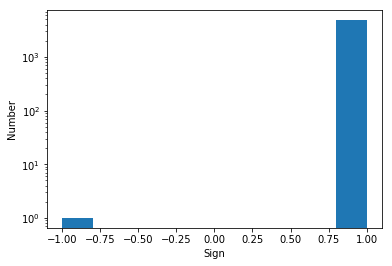

[1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 4.84e+03]

 CONFIRMED


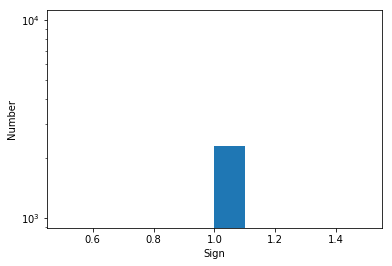

[   0.    0.    0.    0.    0. 2303.    0.    0.    0.    0.]


In [109]:
'''KOI with duration longer than period'''
for i in ['CANDIDATE', 'FALSE POSITIVE', 'CONFIRMED']:
    data_type = data[data.koi_disposition == i]
    
    period = data_type.koi_period
    duration = data_type.koi_duration
    t0 = data_type.koi_time0bk                      
    kid = data_type.kepoi_name                        
    Dt = period*24 - duration                           #Difference between period time and transit duration time
    Dt_sign = np.sign(Dt).astype(int)                            #Sign of the difference. If sign < 0 the transit duration is longer than period
    
    print('\n', i)
    '''Hist plotting'''
    hp = plt.hist(Dt_sign)
    plt.yscale('log')
    plt.ylabel('Number')
    plt.xlabel('Sign')
    plt.show()
    print(hp[0])

In [54]:
'''KOI with duration longer than period'''
for i in ['CANDIDATE', 'FALSE POSITIVE', 'CONFIRMED']:
    data_type = data[(data.koi_disposition == i) & (data.koi_duration >= data.koi_period*24)]
    display(data_type)

,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_period,koi_time0bk,koi_duration,koi_depth,koi_kepmag


,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_period,koi_time0bk,koi_duration,koi_depth,koi_kepmag
8266,5271803,K06549.01,NaN,FALSE POSITIVE,FALSE POSITIVE,NaN,0.540246,131.5521,13.93,1148.0,13.681


,kepid,kepoi_name,kepler_name,koi_disposition,koi_pdisposition,koi_score,koi_period,koi_time0bk,koi_duration,koi_depth,koi_kepmag


Duration is in hours and period in days!!!!!!!

There is just one longer in duration than period

# k-populated lc samples
Those whose transit durations are longer than transit periods

In [55]:
'''Taking samples'''
seed = 12345
k = 5
sample_dic = {}
sample_dic_longer = {}
for i in ['CANDIDATE', 'FALSE POSITIVE', 'CONFIRMED']:
    print('\n', i)
    data_type = data[data.koi_disposition == i]
    
    koi = data_type.kepoi_name
    
    random.seed(seed)
    koi_sample = random.sample(list(koi), k)      #Randomly selected sample with that label. List of length k
    sample_dic[i] = koi_sample                    #DICT that stores all three random samples   


 CANDIDATE

 FALSE POSITIVE

 CONFIRMED


In [65]:
sample_dic

{'CANDIDATE': ['K05388.01',
  'K00134.01',
  'K03411.01',
  'K05022.01',
  'K04409.01'],
 'FALSE POSITIVE': ['K07418.01',
  'K01178.01',
  'K03046.01',
  'K05767.01',
  'K07717.01'],
 'CONFIRMED': ['K00551.01',
  'K00778.01',
  'K02594.01',
  'K00330.01',
  'K01980.01']}

We define the function that we are going to use to flatt the curves

In [56]:
'''We can define the function we wanna apply
to our lc in order to flat it'''

def fcorrector(lc):
    '''Function to flat and normalize light curves:
    - lc (KeplerLightCurve): light curve
    - window_length (int): window length of the flattened curve
    -----------------------------------
    Returns: corrected_lc (KeplerLightCurve)'''

    corrected_lc = lc.remove_nans().normalize().flatten()
    return corrected_lc

# Plotting curves
To avoid time-consuming download operation, I write in some files and then read them again

In [80]:
'''We download lightcurves of those samples using lightkurve's API'''
from time import time
t0 = time()
for i in sample_dic.keys():
    for j in sample_dic[i]:
        koi = list(data[data.kepoi_name == j].kepid)
        print(koi)
        lcfs = lk.search_lightcurvefile('KIC '+ str(koi[0])).download_all().PDCSAP_FLUX.stitch(corrector_func=fcorrector)
        try:
            lcfs.to_fits(
                '/test_notebooks/' + str(j) + 'llc.fits',
            flux_column_name = 'PDCSAP_FLUX')
        except:
            print('ya está')
print(time()-t0)

[4270253]
[11853255]
[8004903]
[11361646]
[11769890]
267.27213287353516


## Plots

### Normal ones

CANDIDATE ------------------------------------------------------------------------------- CANDIDATE
[7416306]
Raw...............kepler name: K05388.01.............................. CANDIDATE



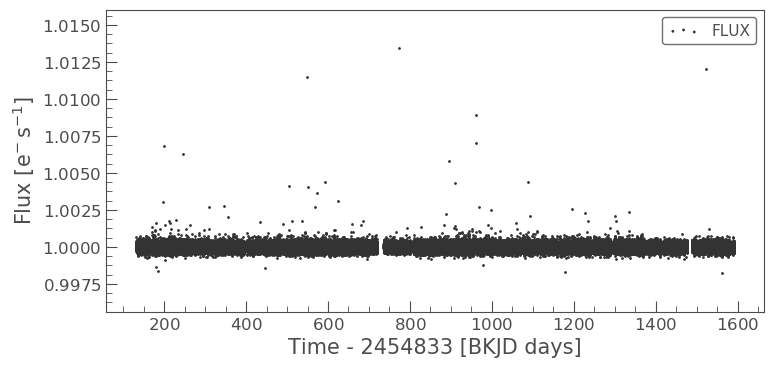

Folded__________

period:  [137.396194] days

label:  ['CANDIDATE']


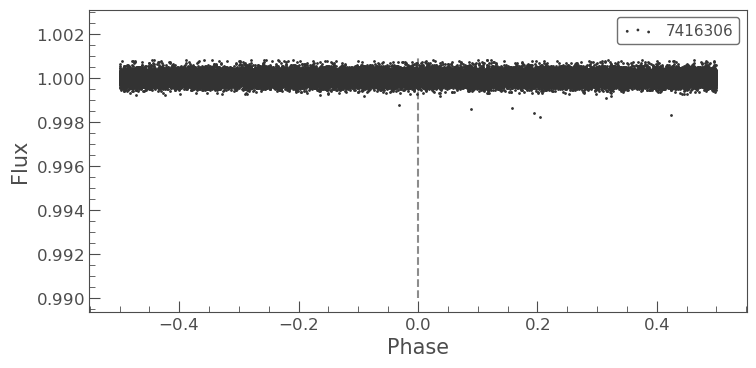

[9032900]
Raw...............kepler name: K00134.01.............................. CANDIDATE



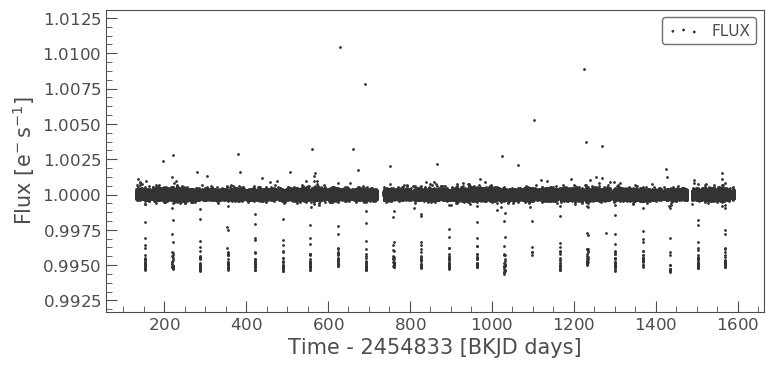

Folded__________

period:  [67.5923754] days

label:  ['CANDIDATE']


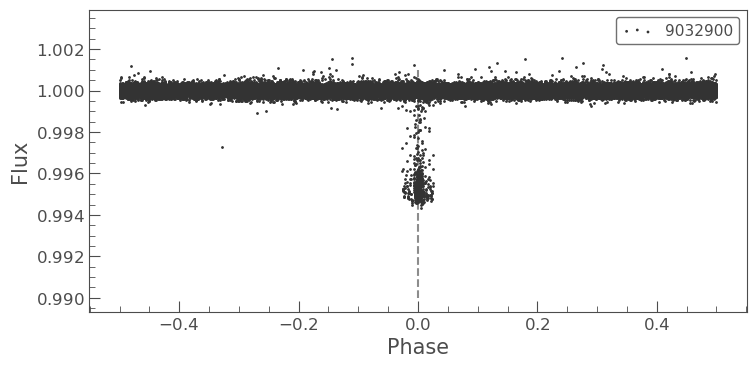

[6025124]
Raw...............kepler name: K03411.01.............................. CANDIDATE



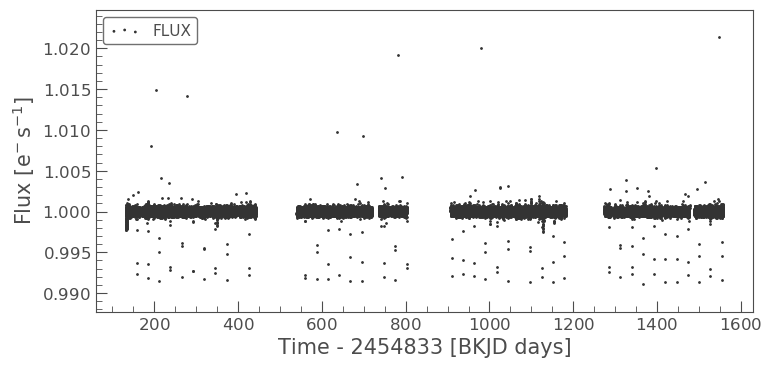

Folded__________

period:  [26.83771808] days

label:  ['CANDIDATE']


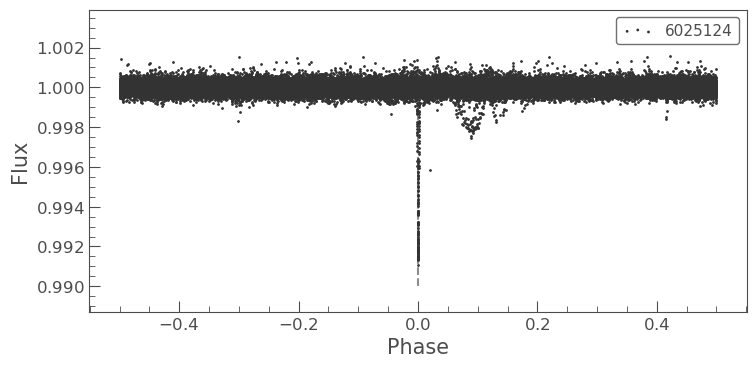

[3865815]
Raw...............kepler name: K05022.01.............................. CANDIDATE



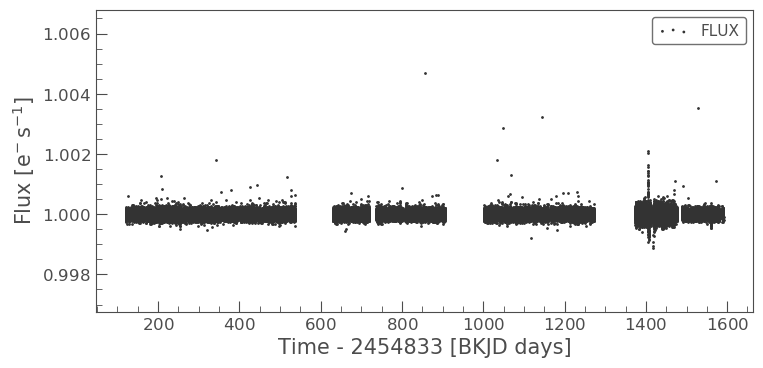

Folded__________

period:  [117.26808432] days

label:  ['CANDIDATE']


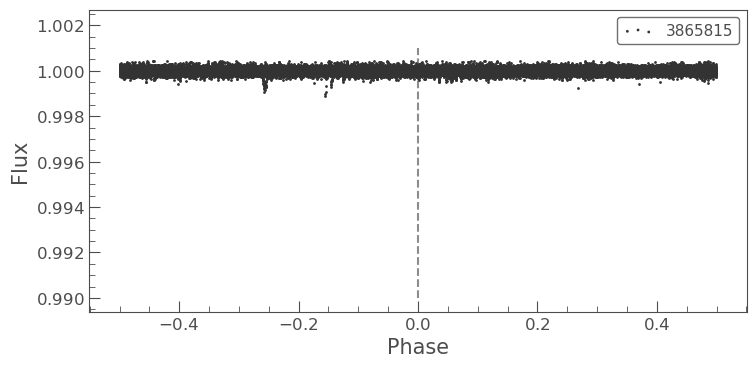

[5308537]
Raw...............kepler name: K04409.01.............................. CANDIDATE



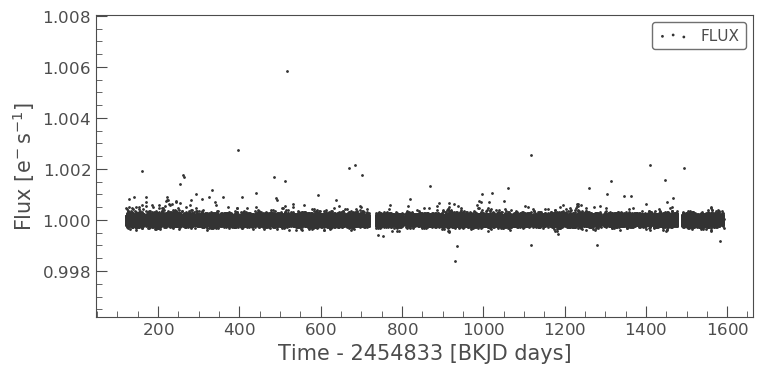

Folded__________

period:  [14.2651545] days

label:  ['CANDIDATE']


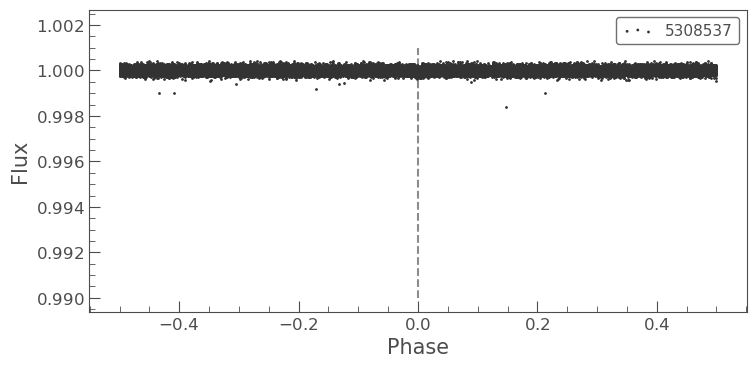

FALSE POSITIVE ------------------------------------------------------------------------------- FALSE POSITIVE
[11199725]
Raw...............kepler name: K07418.01.............................. FALSE POSITIVE



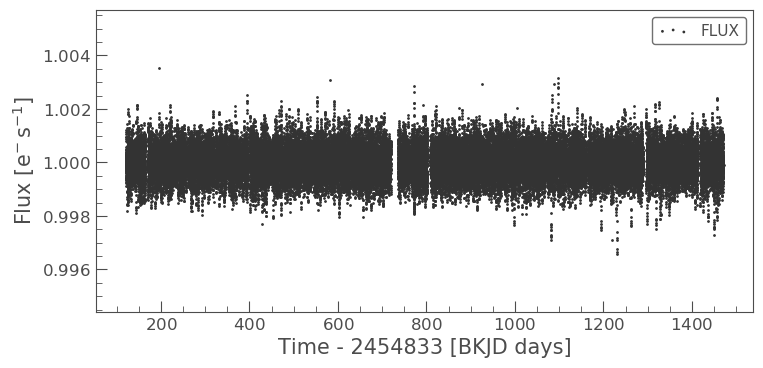

Folded__________

period:  [1.032967155] days

label:  ['FALSE POSITIVE']


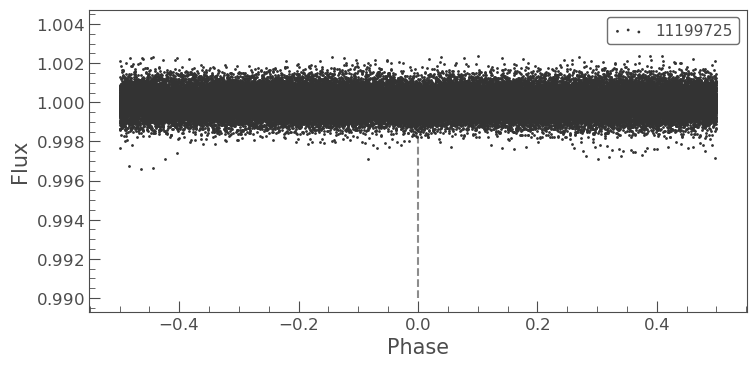

[3869825]
Raw...............kepler name: K01178.01.............................. FALSE POSITIVE



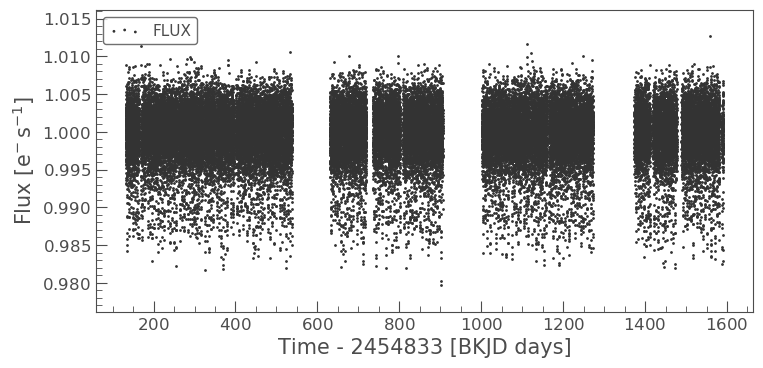

Folded__________

period:  [4.8006539010000004] days

label:  ['FALSE POSITIVE']


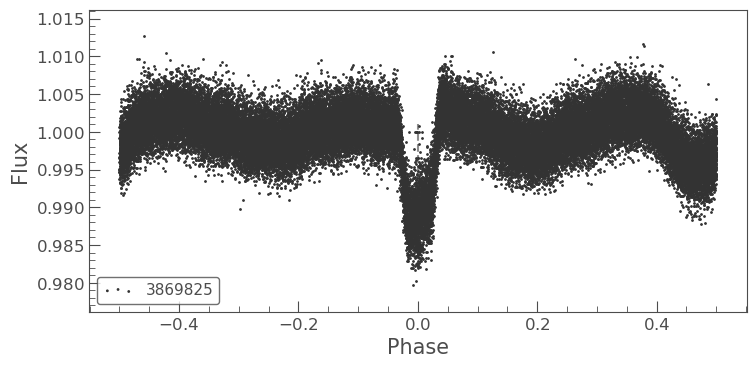

[8161830]
Raw...............kepler name: K03046.01.............................. FALSE POSITIVE



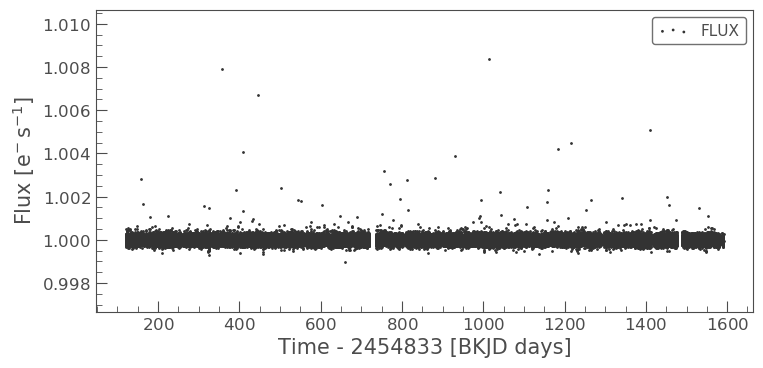

Folded__________

period:  [1.10118564] days

label:  ['FALSE POSITIVE']


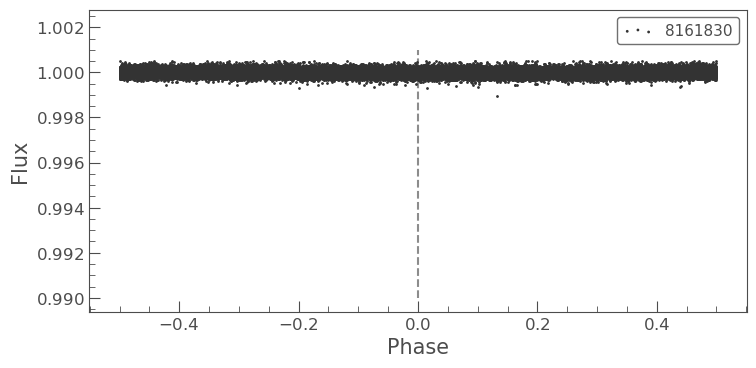

[10132908]
Raw...............kepler name: K05767.01.............................. FALSE POSITIVE



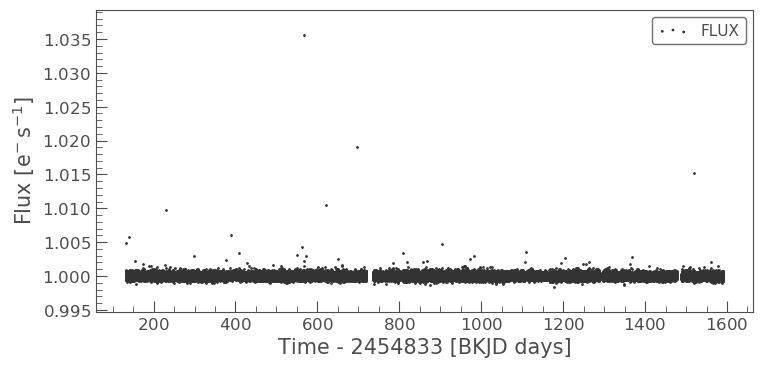

Folded__________

period:  [386.59946] days

label:  ['FALSE POSITIVE']


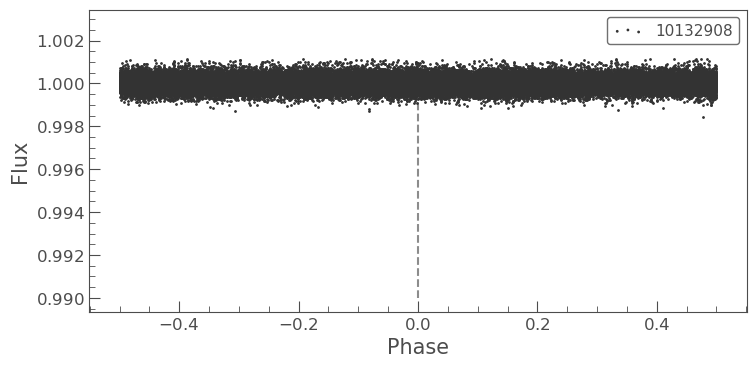

[5120225]
Raw...............kepler name: K07717.01.............................. FALSE POSITIVE



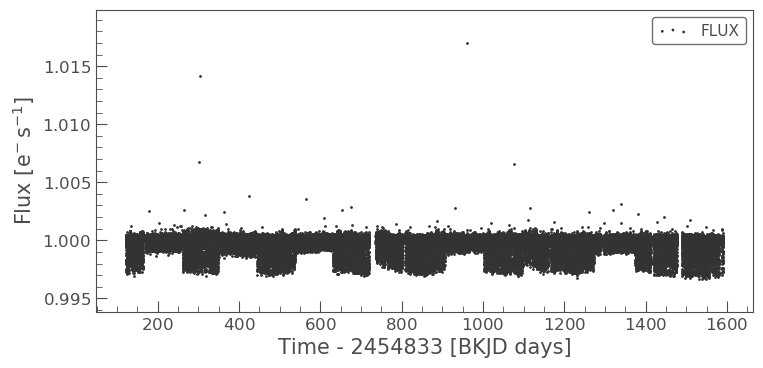

Folded__________

period:  [1.0416199320000001] days

label:  ['FALSE POSITIVE']


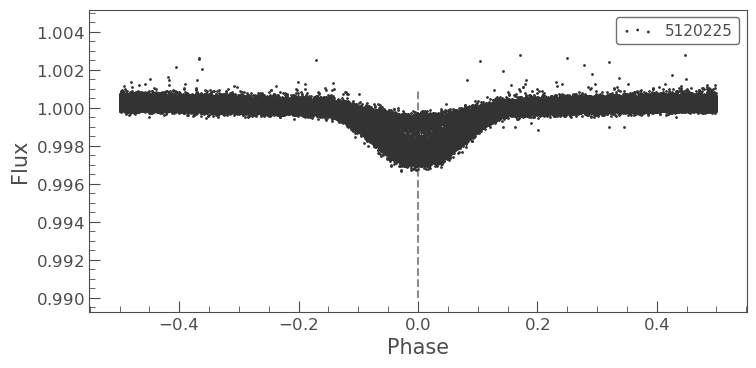

CONFIRMED ------------------------------------------------------------------------------- CONFIRMED
[4270253]
Raw...............kepler name: K00551.01.............................. CONFIRMED



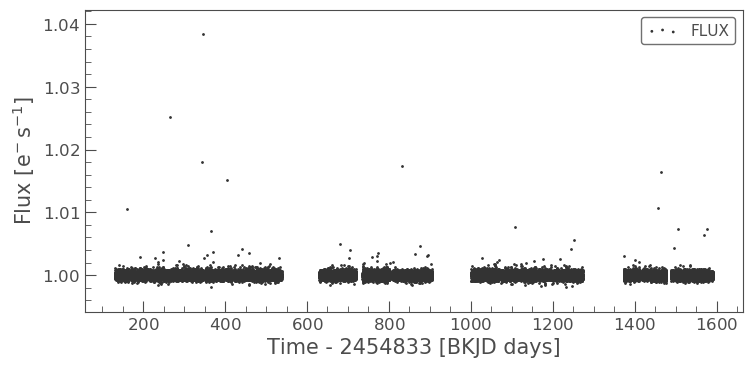

Folded__________

period:  [11.6370303, 5.68798675] days

label:  ['CONFIRMED', 'CONFIRMED']


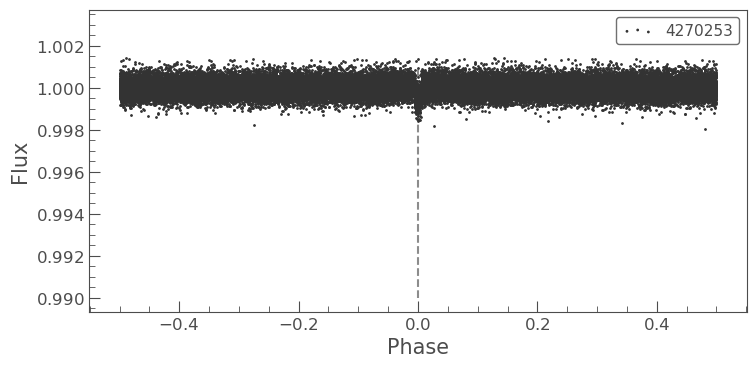

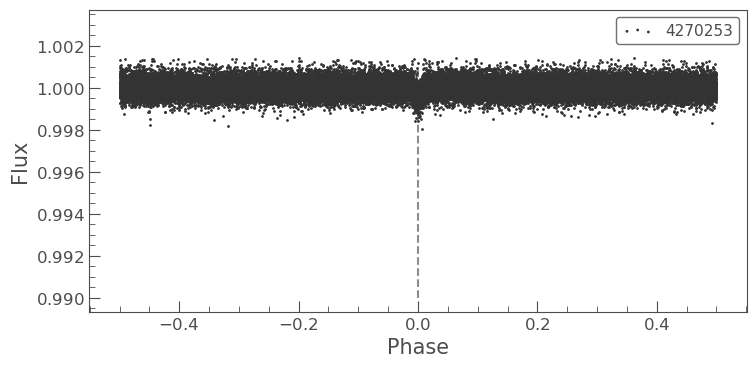

[11853255]
Raw...............kepler name: K00778.01.............................. CONFIRMED



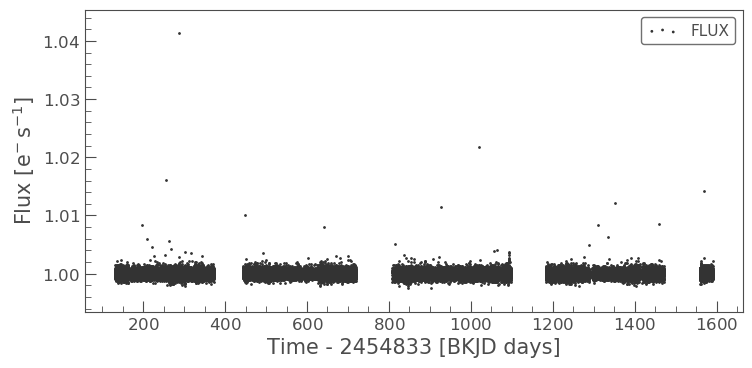

Folded__________

period:  [2.243380573] days

label:  ['CONFIRMED']


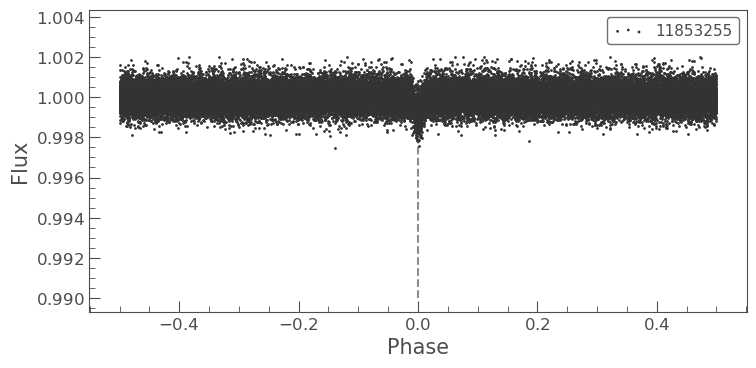

[8004903]
Raw...............kepler name: K02594.01.............................. CONFIRMED



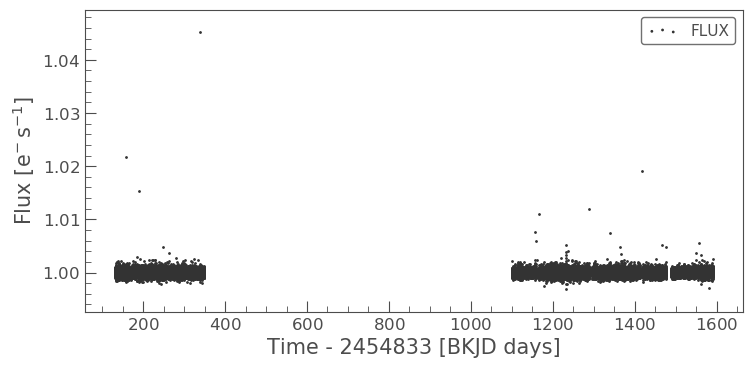

Folded__________

period:  [11.25401871] days

label:  ['CONFIRMED']


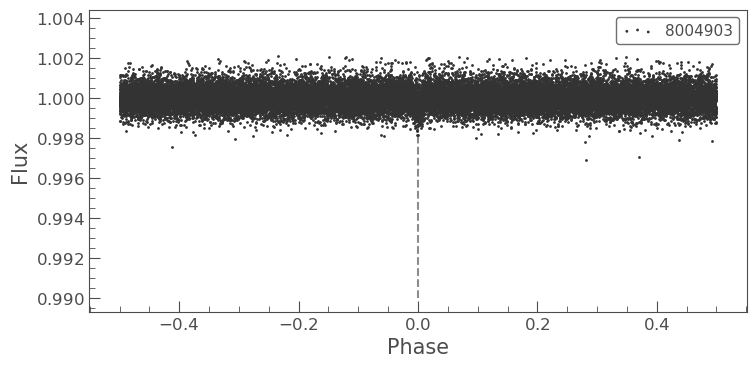

[11361646]
Raw...............kepler name: K00330.01.............................. CONFIRMED



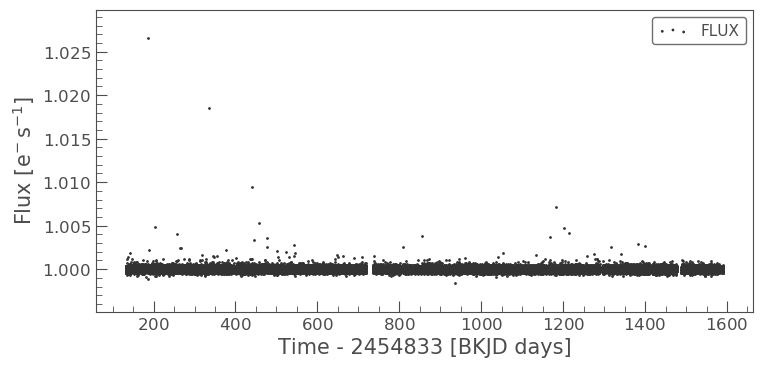

Folded__________

period:  [7.97420583, 1.88899036] days

label:  ['CONFIRMED', 'CONFIRMED']


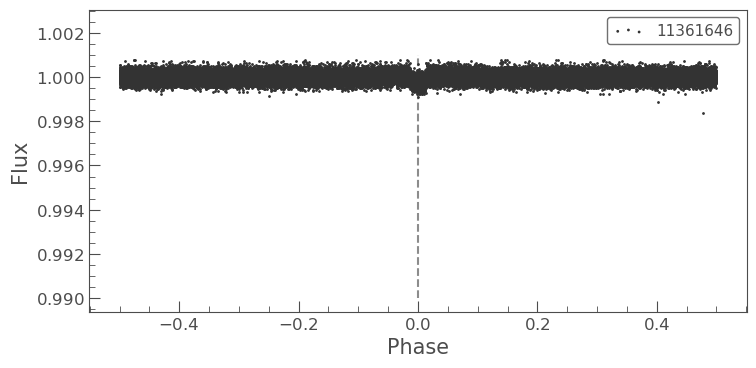

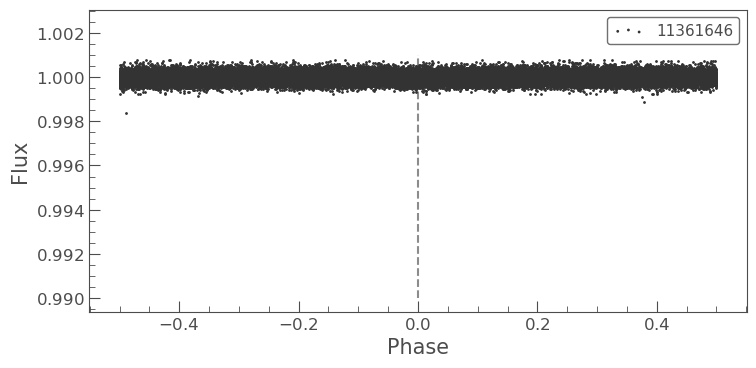

[11769890]
Raw...............kepler name: K01980.01.............................. CONFIRMED



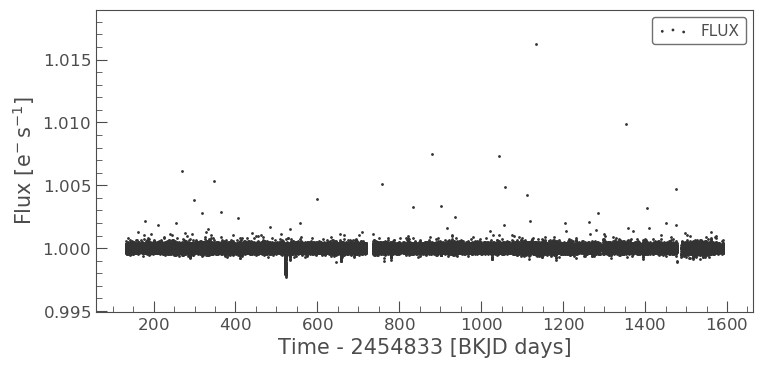

Folded__________

period:  [122.8799543] days

label:  ['CONFIRMED']


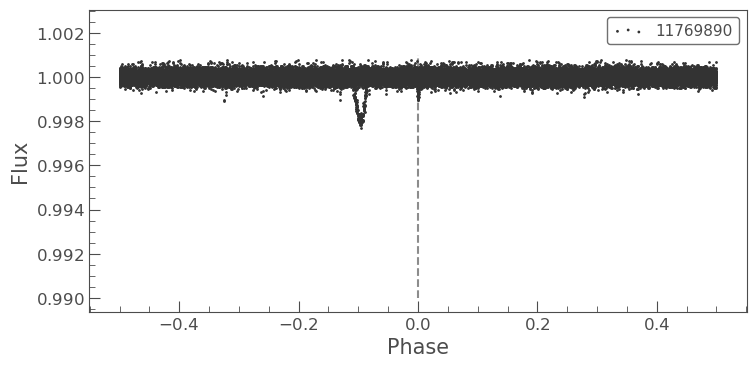

In [88]:
'''Load and paint lightcurves'''

for i in sample_dic.keys():
    print(i, '-------------------------------------------------------------------------------', i)
    for j in sample_dic[i]:
        koi = list(data[data.kepoi_name == j].kepid)
        print(koi)
        print('Raw...............kepler name: ' + str(j) +'.............................. ' + str(i) + '\n')
        path = '/test_notebooks/'
        lc = lk.search.open(path + str(j) + 'llc.fits')   #Read curves (as lc object)
        lc.scatter()                                      #Paint raw curves
        plt.show()         
        
        period = list(data[data.kepid == koi[0]].koi_period)   #Paint same curves but folded by each
        time0  = list(data[data.kepid == koi[0]].koi_time0bk)
        label  = list(data[data.kepid == koi[0]].koi_disposition)
        print('Folded__________\n')
        print('period: ', period, 'days\n')
        print('label: ', label)
        for k in range(len(period)):
            folded_lc = lc.FLUX.fold(period = period[k], t0 = time0[k]).remove_outliers(sigma_lower=float('inf'), sigma_upper=4)
            folded_lc.scatter()
            plt.vlines(x = 0, ymin = 0.99, ymax = 1.001, color = 'grey', linestyles='dashed', alpha = 0.9, zorder = 0)
            plt.show()
        